In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b01bc5e1-f82c-79db-fb19-dd1f989eea57)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Donwload Tacotron

In [ ]:
import os
!git clone -q https://github.com/Yabko2305/taco2_diploma_ukr
os.chdir('taco2_diploma_ukr')
!git submodule init
!git submodule update
!pip install -q unidecode tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.6 MB/s eta 0:00:00


# Upload dataset

This is where you will need to upload your dataset. First, run the cell below. This will make the folder where you will put your audio files.

In [ ]:
train_data_path = 'train_wavs'
test_data_path = 'test_wavs'
!mkdir {train_data_path}
!mkdir {test_data_path}
!mkdir {'filelists'}

Put your train wav files into "train_wavs" folder and your test files into "test_waws" folder. Also, add textfiles test_list.txt and train_list.txt into folder "filelists". Alternatively, if you have the following files on Google Drive, you can use the comands below.

In [ ]:
%cp -r /content/drive/MyDrive/Tacotron_Train/Ukrainian_Mykyta/train_wavs /content/taco2_diploma_ukr/

In [ ]:
%cp -r /content/drive/MyDrive/Tacotron_Train/Ukrainian_Mykyta/test_wavs /content/taco2_diploma_ukr/

In [ ]:
%cp /content/drive/MyDrive/Tacotron_Train/Ukrainian_Mykyta/train_text.txt /content/taco2_diploma_ukr/filelists/
%cp /content/drive/MyDrive/Tacotron_Train/Ukrainian_Mykyta/test_text.txt /content/taco2_diploma_ukr/filelists/

In [ ]:
import tensorflow as tf
from text import symbols
from tensorboard.plugins.hparams import api as hp
from collections import namedtuple

def get_hparams(**kwargs):
    return namedtuple('GenericDict', kwargs.keys())(**kwargs)

def create_hparams(hparams_string=None, verbose=False):
    """Create model hyperparameters. Parse nondefault from given string."""

    hparams = get_hparams(
        ################################
        # Experiment Parameters        #
        ################################
        iters_per_checkpoint=1000,
        seed=1234,
        dynamic_loss_scaling=True,
        fp16_run=False,
        distributed_run=False,
        dist_backend="nccl",
        dist_url="tcp://localhost:54321",
        cudnn_enabled=True,
        cudnn_benchmark=False,
        ignore_layers=[],

        ################################
        # Data Parameters             #
        ################################
        load_mel_from_disk=True,
        text_cleaners=['ukr_non_trans_cleaners'],

        ################################
        # Audio Parameters             #
        ################################
        max_wav_value=4000768.0,
        sampling_rate=22050,
        filter_length=1024,
        hop_length=256,
        win_length=1024,
        n_mel_channels=80,
        mel_fmin=0.0,
        mel_fmax=8000.0,

        ################################
        # Model Parameters             #
        ################################
        n_symbols=len(symbols),
        symbols_embedding_dim=512,

        # Encoder parameters
        encoder_kernel_size=5,
        encoder_n_convolutions=3,
        encoder_embedding_dim=512,

        # Decoder parameters
        n_frames_per_step=1,  # currently only 1 is supported
        decoder_rnn_dim=1024,
        prenet_dim=256,
        max_decoder_steps=1000,
        gate_threshold=0.5,

        # Attention parameters
        attention_rnn_dim=1024,
        attention_dim=128,

        # Location Layer parameters
        attention_location_n_filters=32,
        attention_location_kernel_size=31,

        # Mel-post processing network parameters
        postnet_embedding_dim=512,
        postnet_kernel_size=5,
        postnet_n_convolutions=5,

        ################################
        # Optimization Hyperparameters #
        ################################
        use_saved_learning_rate=False,
        learning_rate=1e-5,
        weight_decay=1e-6,
        grad_clip_thresh=1.0,
        mask_padding=True,  # set model's padded outputs to padded values
        training_files = "/content/taco2_diploma_ukr/filelists/train_text.txt",
        validation_files = "/content/taco2_diploma_ukr/filelists/test_text.txt",
        cleaners='transliteration_cleaners',

        batch_size = 64,
        epochs =  100,

        p_attention_dropout=0.1,
        p_decoder_dropout=0.1,
        decay_start = 15000,
        A_ = 1e-5,  # Starting learning rate
        B_ = 8000,
        C_ = 0,
        min_learning_rate = 1e-5,
        show_alignments = True
    )


    if hparams_string:
        tf.logging.info('Parsing command line hparams: %s', hparams_string)
        hparams.parse(hparams_string)

    if verbose:
        tf.logging.info('Final parsed hparams: %s', hparams.values())

    return hparams


/content/taco2_diploma_ukr/text/__init__.py:74: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'
/content/taco2_diploma_ukr/text/__init__.py:74: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'


# Model and Data preparation


In [ ]:
%matplotlib inline
import os

if os.getcwd() != '/content/taco2_diploma_ukr':
  os.chdir('taco2_diploma_ukr')
import time
import argparse
import math
from numpy import finfo

import torch
from distributed import apply_gradient_allreduce
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader

from model import Tacotron2
from data_utils import TextMelCollate
from loss_function import Tacotron2Loss
from logger import Tacotron2Logger
from layers import TacotronSTFT
from data_utils import TextMelLoader
#from hparams import create_hparams

import random
import numpy as np

from utils import load_wav_to_torch, load_filepaths_and_text
from math import e

from tqdm.notebook import tqdm
from distutils.dir_util import copy_tree
import matplotlib.pylab as plt

def load_model(hparams):
    model = Tacotron2(hparams).cuda()
    if hparams.fp16_run:
        model.decoder.attention_layer.score_mask_value = finfo('float16').min

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    return model

def create_mels(generate_noise):
    print("Generating Mels")
    stft = TacotronSTFT(
                hparams.filter_length, hparams.hop_length, hparams.win_length,
                hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                hparams.mel_fmax)
    def save_mel(filename, generate_noise):
        audio, sampling_rate = load_wav_to_torch(filename)
        if sampling_rate != stft.sampling_rate:
            raise ValueError("{} {} SR doesn't match target {} SR".format(filename,
                sampling_rate, stft.sampling_rate))
        if generate_noise:
          audio = audio + random.randint(-2,2)
        audio_norm = audio / hparams.max_wav_value
        print(filename)
        print(f'Audio: {torch.min(audio)}, Norm: {hparams.max_wav_value}')
        audio_norm = audio_norm.unsqueeze(0)
        audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
        melspec = stft.mel_spectrogram(audio_norm)
        melspec = torch.squeeze(melspec, 0).cpu().numpy()
        np.save(filename.replace('.wav', ''), melspec)

    import glob
    train_wavs = glob.glob('/content/taco2_diploma_ukr/train_wavs/*.wav')
    test_wavs = glob.glob('/content/taco2_diploma_ukr/test_wavs/*.wav')
    for i in tqdm(train_wavs):
        save_mel(i, generate_noise)
    for i in tqdm(test_wavs):
        save_mel(i, False)


def reduce_tensor(tensor, n_gpus):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.reduce_op.SUM)
    rt /= n_gpus
    return rt


def init_distributed(hparams, n_gpus, rank, group_name):
    assert torch.cuda.is_available(), "Distributed mode requires CUDA."
    print("Initializing Distributed")

    # Set cuda device so everything is done on the right GPU.
    torch.cuda.set_device(rank % torch.cuda.device_count())

    # Initialize distributed communication
    dist.init_process_group(
        backend=hparams.dist_backend, init_method=hparams.dist_url,
        world_size=n_gpus, rank=rank, group_name=group_name)

    print("Done initializing distributed")


def prepare_directories_and_logger(output_directory, log_directory, rank):
    if rank == 0:
        if not os.path.isdir(output_directory):
            os.makedirs(output_directory)
            os.chmod(output_directory, 0o775)
        logger = Tacotron2Logger(os.path.join(output_directory, log_directory))
    else:
        logger = None
    return logger



def prepare_dataloaders(hparams):
    # Get data, data loaders and collate function ready
    trainset = TextMelLoader(hparams.training_files, hparams)
    valset = TextMelLoader(hparams.validation_files, hparams)
    collate_fn = TextMelCollate(hparams.n_frames_per_step)

    if hparams.distributed_run:
        train_sampler = DistributedSampler(trainset)
        shuffle = False
    else:
        train_sampler = None
        shuffle = True

    train_loader = DataLoader(trainset, num_workers=1, shuffle=shuffle,
                              sampler=train_sampler,
                              batch_size=hparams.batch_size, pin_memory=False,
                              drop_last=True, collate_fn=collate_fn)
    return train_loader, valset, collate_fn


def warm_start_model(checkpoint_path, model, ignore_layers):
    assert os.path.isfile(checkpoint_path)
    print("Warm starting model from checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = checkpoint_dict['state_dict']
    if len(ignore_layers) > 0:
        model_dict = {k: v for k, v in model_dict.items()
                      if k not in ignore_layers}
        dummy_dict = model.state_dict()
        dummy_dict.update(model_dict)
        model_dict = dummy_dict
    model.load_state_dict(model_dict)
    return model


def load_checkpoint(checkpoint_path, model, optimizer):
    assert os.path.isfile(checkpoint_path)
    print("Loading checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint_dict['state_dict'])
    optimizer.load_state_dict(checkpoint_dict['optimizer'])
    learning_rate = checkpoint_dict['learning_rate']
    iteration = checkpoint_dict['iteration']
    print("Loaded checkpoint '{}' from iteration {}" .format(
        checkpoint_path, iteration))
    return model, optimizer, learning_rate, iteration


def save_checkpoint(model, optimizer, learning_rate, iteration, filepath):
    print("Saving model and optimizer state at iteration {} to {}".format(
        iteration, filepath))
    try:
        torch.save({'iteration': iteration,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'learning_rate': learning_rate}, filepath)
    except KeyboardInterrupt:
        print("interrupt received while saving, waiting for save to complete.")
        torch.save({'iteration': iteration,'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(),'learning_rate': learning_rate}, filepath)
    print("Model Saved")

def plot_alignment(alignment, info=None):
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(int(alignment_graph_width/100), int(alignment_graph_height/100)))
    im = ax.imshow(alignment, cmap='inferno', aspect='auto', origin='lower',
                   interpolation='none')
    ax.autoscale(enable=True, axis="y", tight=True)
    fig.colorbar(im, ax=ax)
    xlabel = 'Decoder timestep'
    if info is not None:
        xlabel += '\n\n' + info
    plt.xlabel(xlabel)
    plt.ylabel('Encoder timestep')
    plt.tight_layout()
    fig.canvas.draw()
    plt.show()

def validate(model, criterion, valset, iteration, batch_size, n_gpus,
             collate_fn, logger, distributed_run, rank, epoch, start_eposh, learning_rate):
    """Handles all the validation scoring and printing"""
    model.eval()
    with torch.no_grad():
        val_sampler = DistributedSampler(valset) if distributed_run else None
        val_loader = DataLoader(valset, sampler=val_sampler, num_workers=1,
                                shuffle=False, batch_size=batch_size,
                                pin_memory=False, collate_fn=collate_fn)

        val_loss = 0.0
        for i, batch in enumerate(val_loader):
            x, y = model.parse_batch(batch)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            if distributed_run:
                reduced_val_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_val_loss = loss.item()
            val_loss += reduced_val_loss
        val_loss = val_loss / (i + 1)

    model.train()
    if rank == 0:
        print("Epoch: {} Validation loss {}: {:9f}  Time: {:.1f}m LR: {:.6f}".format(epoch, iteration, val_loss,(time.perf_counter()-start_eposh)/60, learning_rate))
        logger.log_validation(val_loss, model, y, y_pred, iteration)
        if hparams.show_alignments:
            %matplotlib inline
            _, mel_outputs, gate_outputs, alignments = y_pred
            idx = random.randint(0, alignments.size(0) - 1)
            plot_alignment(alignments[idx].data.cpu().numpy().T)

def train(output_directory, log_directory, checkpoint_path, warm_start, n_gpus,
          rank, group_name, hparams, log_directory2):
    if hparams.distributed_run:
        init_distributed(hparams, n_gpus, rank, group_name)

    torch.manual_seed(hparams.seed)
    torch.cuda.manual_seed(hparams.seed)

    model = load_model(hparams)
    learning_rate = hparams.learning_rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                                 weight_decay=hparams.weight_decay)

    criterion = Tacotron2Loss()

    logger = prepare_directories_and_logger(
        output_directory, log_directory, rank)

    train_loader, valset, collate_fn = prepare_dataloaders(hparams)

    # # Load checkpoint if one exists
    iteration = 0
    epoch_offset = 0
    if checkpoint_path is not None and os.path.isfile(checkpoint_path):
        if warm_start:
            model = warm_start_model(
                checkpoint_path, model, hparams.ignore_layers)
        else:
            model, optimizer, _learning_rate, iteration = load_checkpoint(
                checkpoint_path, model, optimizer)
            if hparams.use_saved_learning_rate:
                learning_rate = _learning_rate
            iteration += 1  # next iteration is iteration + 1
            epoch_offset = max(0, int(iteration / len(train_loader)))
    else:
      if not os.path.isfile("pretrained_model"):
        !gdown --id 1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA
        !mv 'tacotron2_statedict.pt' 'pretrained_model'
      model = warm_start_model("pretrained_model", model, hparams.ignore_layers)

    start_eposh = time.perf_counter()
    learning_rate = 0.0
    model.train()
    is_overflow = False
    # ================ MAIN TRAINNIG LOOP! ===================
    for epoch in tqdm(range(epoch_offset, hparams.epochs)):
        print("\nStarting Epoch: {} Iteration: {}".format(epoch, iteration))
        start_eposh = time.perf_counter()
        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
            start = time.perf_counter()
            if iteration < hparams.decay_start: learning_rate = hparams.A_
            else: iteration_adjusted = iteration - hparams.decay_start; learning_rate = (hparams.A_*(e**(-iteration_adjusted/hparams.B_))) + hparams.C_
            learning_rate = max(hparams.min_learning_rate, learning_rate) # output the largest number
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate

            model.zero_grad()
            x, y = model.parse_batch(batch)
            y_pred = model(x)

            loss = criterion(y_pred, y)
            if hparams.distributed_run:
                reduced_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_loss = loss.item()
            if hparams.fp16_run:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            if hparams.fp16_run:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    amp.master_params(optimizer), hparams.grad_clip_thresh)
                is_overflow = math.isnan(grad_norm)
            else:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    model.parameters(), hparams.grad_clip_thresh)

            optimizer.step()

            if not is_overflow and rank == 0:
                duration = time.perf_counter() - start
                logger.log_training(
                    reduced_loss, grad_norm, learning_rate, duration, iteration)


            iteration += 1
        validate(model, criterion, valset, iteration,
                 hparams.batch_size, n_gpus, collate_fn, logger,
                 hparams.distributed_run, rank, epoch, start_eposh, learning_rate)
        save_checkpoint(model, optimizer, learning_rate, iteration, checkpoint_path)
        if log_directory2 != None:
            copy_tree(log_directory, log_directory2)


def check_dataset(hparams):
    from utils import load_wav_to_torch, load_filepaths_and_text
    import os
    import numpy as np
    def check_arr(filelist_arr):
        for i, file in enumerate(filelist_arr):
            if len(file) > 2:
                print("|".join(file), "\nhas multiple '|', this may not be an error.")
            if hparams.load_mel_from_disk and '.wav' in file[0]:
                print("[WARNING]", file[0], " in filelist while expecting .npy .")
            else:
                if not hparams.load_mel_from_disk and '.npy' in file[0]:
                    print("[WARNING]", file[0], " in filelist while expecting .wav .")
            if (not os.path.exists(file[0])):
                print("".join(file[0]), "\n[WARNING] does not exist.")
                print(os.getcwd())
            if len(file[1]) < 3:
                print("|".join(file), "\n[info] has no/very little text.")
            if not ((file[1].strip())[-1] in r"!?,.;:"):
                print("|".join(file), "\n[info] has no ending punctuation.")
            mel_length = 1
            if hparams.load_mel_from_disk and '.npy' in file[0]:
                melspec = torch.from_numpy(np.load(file[0], allow_pickle=True))
                mel_length = melspec.shape[1]
            if mel_length == 0:
                print("|".join(file), "\n[WARNING] has 0 duration.")
    print("Checking Training Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.training_files)
    check_arr(audiopaths_and_text)
    print("Checking Validation Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.validation_files)
    check_arr(audiopaths_and_text)
    print("Finished Checking")


warm_start=False
n_gpus=1
rank=0
group_name=None
hparams = create_hparams()
model_filename = 'current_model'

Now, replace .wav with .npy in filelists

In [ ]:
!sed -i -- 's,.wav|,.npy|,g' /content/taco2_diploma_ukr/filelists/*.txt

Put the name of the model

In [ ]:
#@title Name the model

model_filename = "ukrainian_test_mykyta_non_trans" #@param {type:"string"}

Enter names of your filelists

In [ ]:
#@title Set the parameters

train_with_noise = False #@param {type:"boolean"}
generate_mels = True # Don't change
alignment_graph_height = 600
alignment_graph_width = 1000


torch.backends.cudnn.enabled = hparams.cudnn_enabled
torch.backends.cudnn.benchmark = hparams.cudnn_benchmark
output_directory = '/content/drive/My Drive/colab/outdir' #@param {type:"string"}
log_directory = '/content/taco2_diploma_ukr/logs' #@param {type:"string"}
log_directory2 = '/content/drive/My Drive/colab/logs'#@param {type:"string"}
checkpoint_path = output_directory+(r'/')+model_filename #@param {type:"string"}

### Create MEL spectrograms

The MEL spectrograms are the input for the AI.

In [ ]:
if generate_mels:
    create_mels(train_with_noise)

Generating Mels


  0%|          | 0/5436 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
/content/taco2_diploma_ukr/train_wavs/62554.wav
Audio: -6011.0, Norm: 4000768.0
/content/taco2_diploma_ukr/train_wavs/68232.wav
Audio: -4132.0, Norm: 4000768.0
/content/taco2_diploma_ukr/train_wavs/55099.wav
Audio: -12739.0, Norm: 4000768.0
/content/taco2_diploma_ukr/train_wavs/58268.wav
Audio: -4364.0, Norm: 4000768.0
/content/taco2_diploma_ukr/train_wavs/57592.wav
Audio: -8623.0, Norm: 4000768.0
/content/taco2_diploma_ukr/train_wavs/60721.wav
Audio: -3695.0, Norm: 4000768.0
/content/taco2_diploma_ukr/train_wavs/60038.wav
Audio: -3562.0, Norm: 4000768.0
/content/taco2_diploma_ukr/train_wavs/59336.wav
Audio: -5994.0, Norm: 4000768.0
/content/taco2_diploma_ukr/train_wavs/60800.wav
Audio: -2586.0, Norm: 4000768.0
/content/taco2_diploma_ukr/train_wavs/68370.wav
Audio: -3948.0, Norm: 4000768.0
/content/taco2_diploma_ukr/train_wavs/58249.wav
Audio: -4604.0, Norm: 4000768.0
/content/taco2_diploma_ukr/train_wavs/55435.wav
Audio: -10520.0, Nor

  0%|          | 0/1000 [00:00<?, ?it/s]

/content/taco2_diploma_ukr/test_wavs/54202.wav
Audio: -17850.0, Norm: 4000768.0
/content/taco2_diploma_ukr/test_wavs/53938.wav
Audio: -13407.0, Norm: 4000768.0
/content/taco2_diploma_ukr/test_wavs/54267.wav
Audio: -8198.0, Norm: 4000768.0
/content/taco2_diploma_ukr/test_wavs/53526.wav
Audio: -8444.0, Norm: 4000768.0
/content/taco2_diploma_ukr/test_wavs/53597.wav
Audio: -11963.0, Norm: 4000768.0
/content/taco2_diploma_ukr/test_wavs/54180.wav
Audio: -12009.0, Norm: 4000768.0
/content/taco2_diploma_ukr/test_wavs/53956.wav
Audio: -16137.0, Norm: 4000768.0
/content/taco2_diploma_ukr/test_wavs/53394.wav
Audio: -15725.0, Norm: 4000768.0
/content/taco2_diploma_ukr/test_wavs/53703.wav
Audio: -10883.0, Norm: 4000768.0
/content/taco2_diploma_ukr/test_wavs/54872.wav
Audio: -11173.0, Norm: 4000768.0
/content/taco2_diploma_ukr/test_wavs/53494.wav
Audio: -16152.0, Norm: 4000768.0
/content/taco2_diploma_ukr/test_wavs/54172.wav
Audio: -8773.0, Norm: 4000768.0
/content/taco2_diploma_ukr/test_wavs/53444.

### Check data

This cell will go through the dataset one more time to see if anything's wrong before training starts.

In [ ]:
check_dataset(hparams)

Checking Training Files
Checking Validation Files
Finished Checking


# Start training!

This next cell will begin training the model!

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA
To: /content/taco2_diploma_ukr/tacotron2_statedict.pt
100% 113M/113M [00:01<00:00, 76.6MB/s]
Warm starting model from checkpoint 'pretrained_model'


  0%|          | 0/100 [00:00<?, ?it/s]


Starting Epoch: 0 Iteration: 0


  0%|          | 0/84 [00:00<?, ?it/s]

/content/taco2_diploma_ukr/utils.py:8: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  ids = torch.arange(0, max_len, out=torch.cuda.LongTensor(max_len))


Epoch: 0 Validation loss 84:  0.790329  Time: 4.6m LR: 0.000010


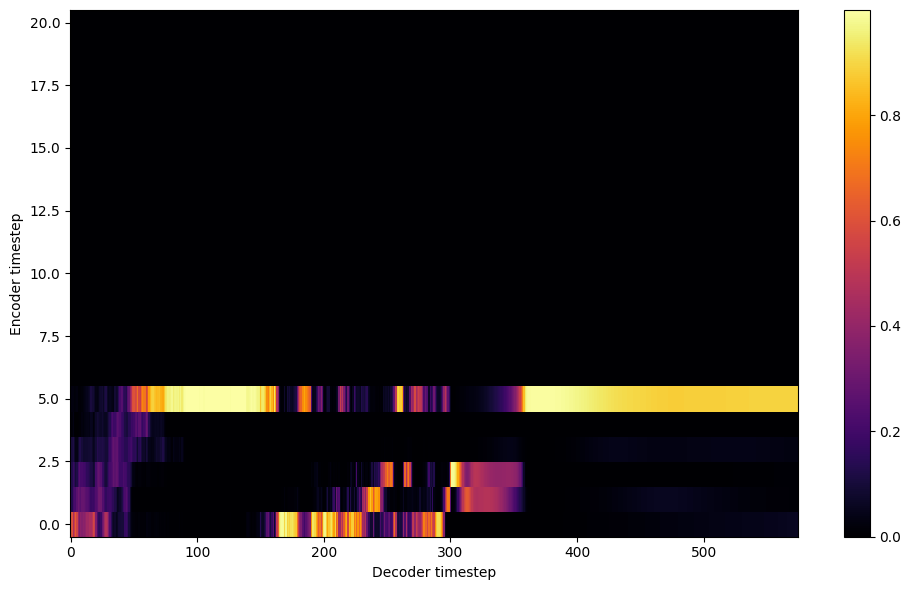

Saving model and optimizer state at iteration 84 to /content/drive/My Drive/colab/outdir/ukrainian_test_mykyta_non_trans
Model Saved

Starting Epoch: 1 Iteration: 84


  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 1 Validation loss 168:  0.392333  Time: 4.6m LR: 0.000010


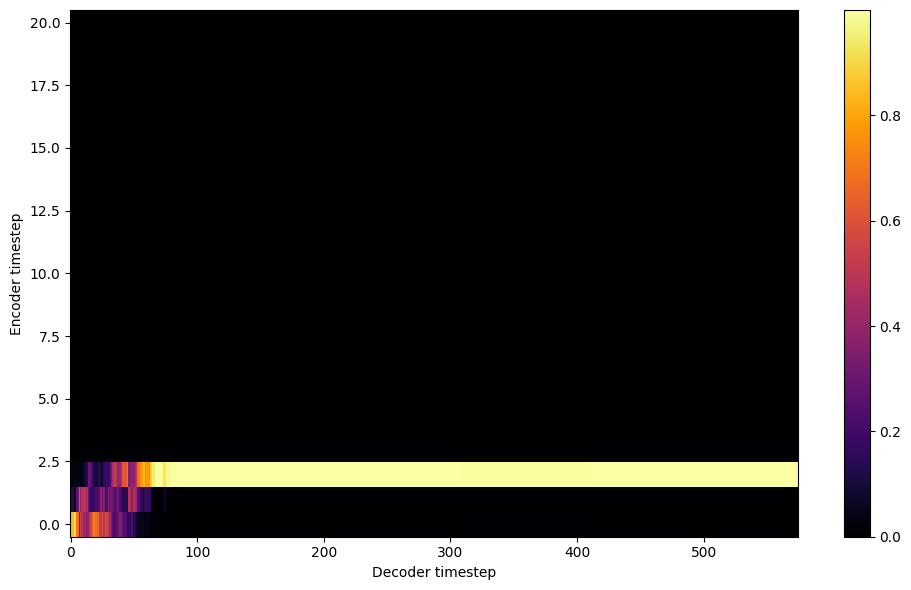

Saving model and optimizer state at iteration 168 to /content/drive/My Drive/colab/outdir/ukrainian_test_mykyta_non_trans
Model Saved

Starting Epoch: 2 Iteration: 168


  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 2 Validation loss 252:  0.313605  Time: 4.6m LR: 0.000010


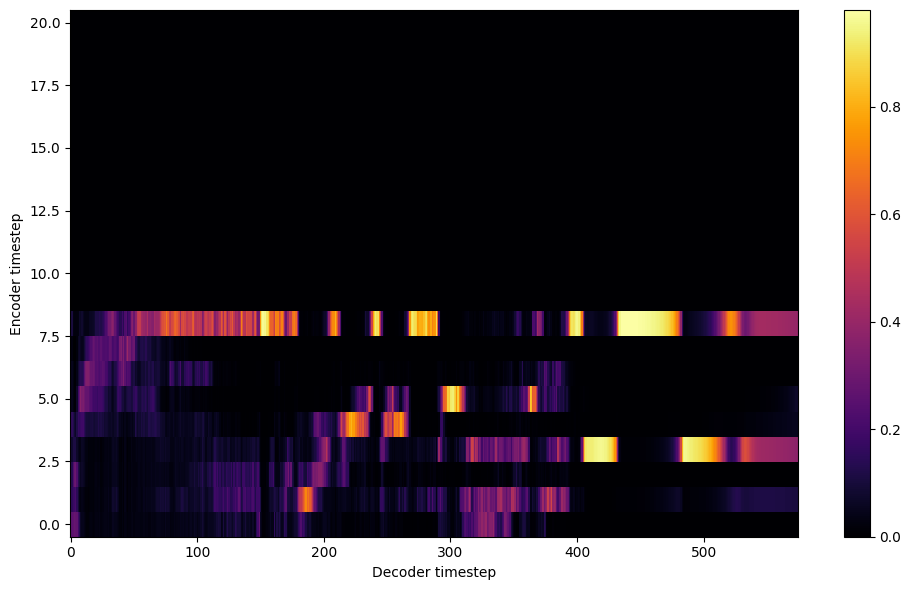

Saving model and optimizer state at iteration 252 to /content/drive/My Drive/colab/outdir/ukrainian_test_mykyta_non_trans
Model Saved

Starting Epoch: 3 Iteration: 252


  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 3 Validation loss 336:  0.286667  Time: 4.6m LR: 0.000010


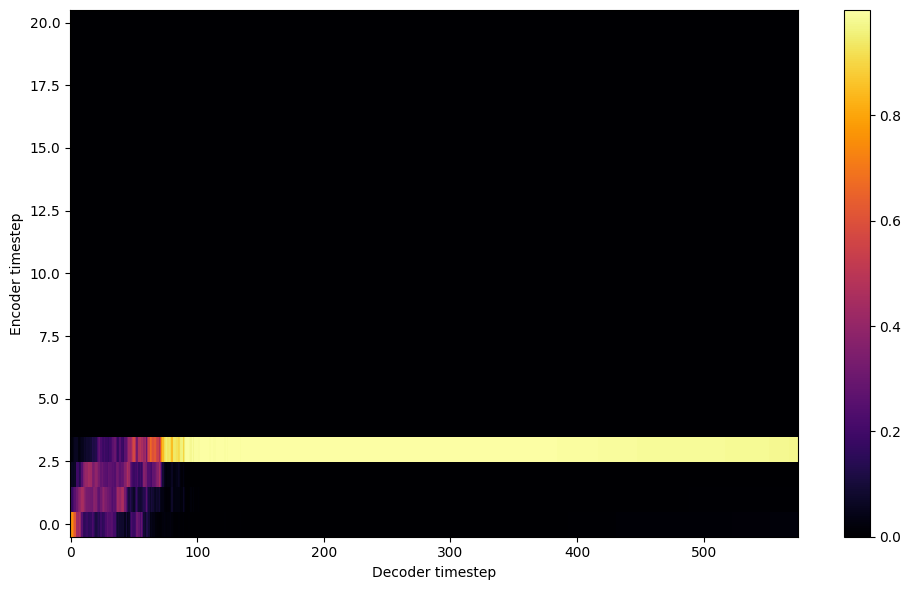

Saving model and optimizer state at iteration 336 to /content/drive/My Drive/colab/outdir/ukrainian_test_mykyta_non_trans
Model Saved

Starting Epoch: 4 Iteration: 336


  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 4 Validation loss 420:  0.272480  Time: 4.6m LR: 0.000010


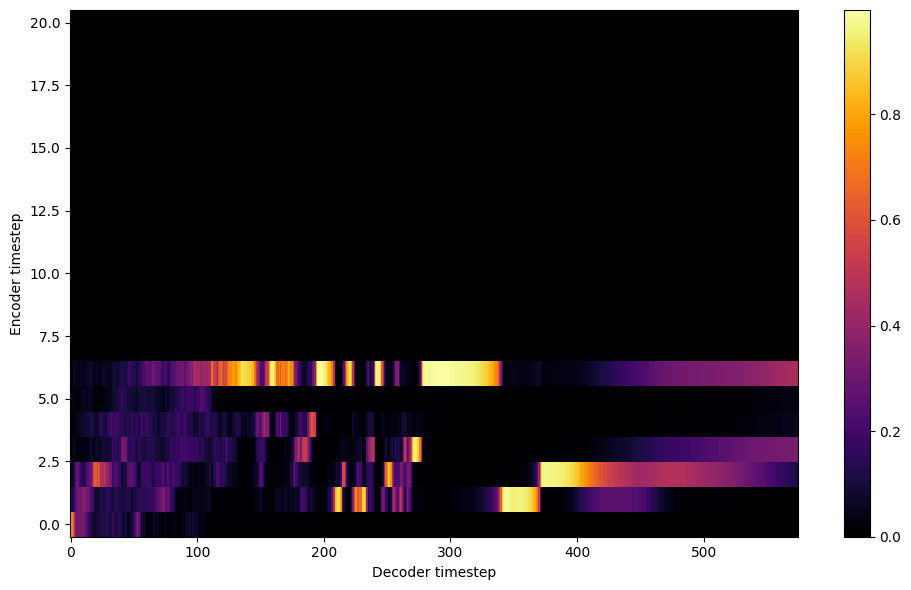

Saving model and optimizer state at iteration 420 to /content/drive/My Drive/colab/outdir/ukrainian_test_mykyta_non_trans
Model Saved

Starting Epoch: 5 Iteration: 420


  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 5 Validation loss 504:  0.263504  Time: 4.6m LR: 0.000010


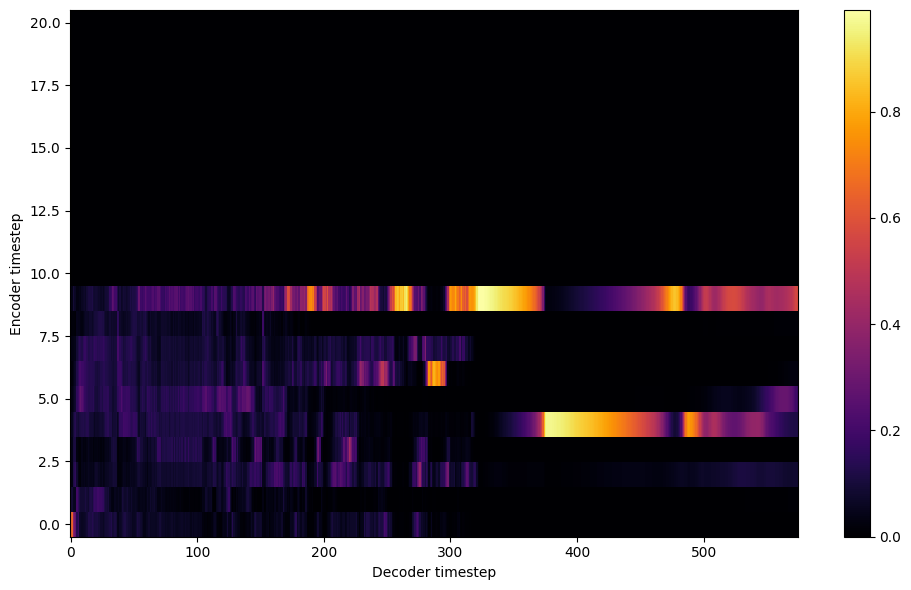

Saving model and optimizer state at iteration 504 to /content/drive/My Drive/colab/outdir/ukrainian_test_mykyta_non_trans
Model Saved

Starting Epoch: 6 Iteration: 504


  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 6 Validation loss 588:  0.256924  Time: 4.6m LR: 0.000010


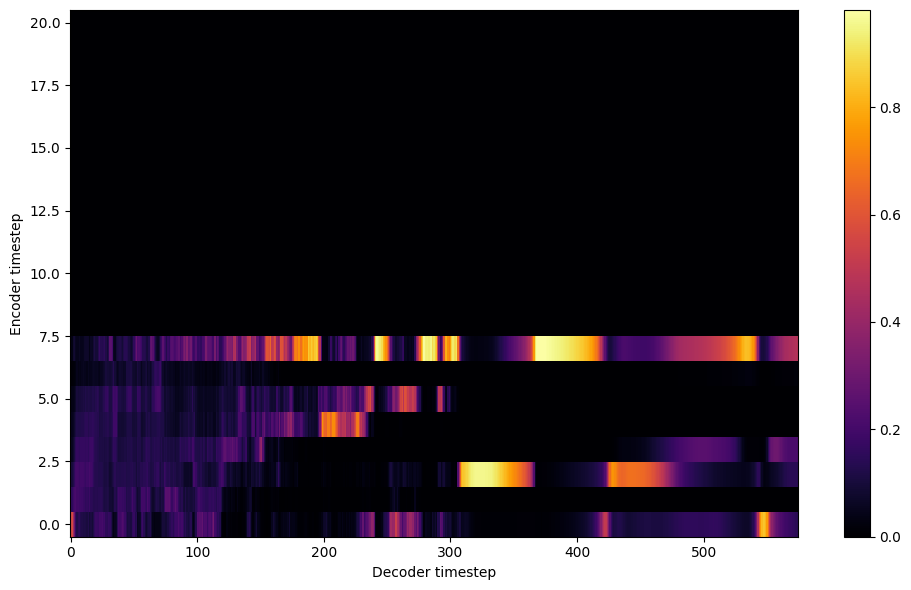

Saving model and optimizer state at iteration 588 to /content/drive/My Drive/colab/outdir/ukrainian_test_mykyta_non_trans
Model Saved

Starting Epoch: 7 Iteration: 588


  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 7 Validation loss 672:  0.251882  Time: 4.7m LR: 0.000010


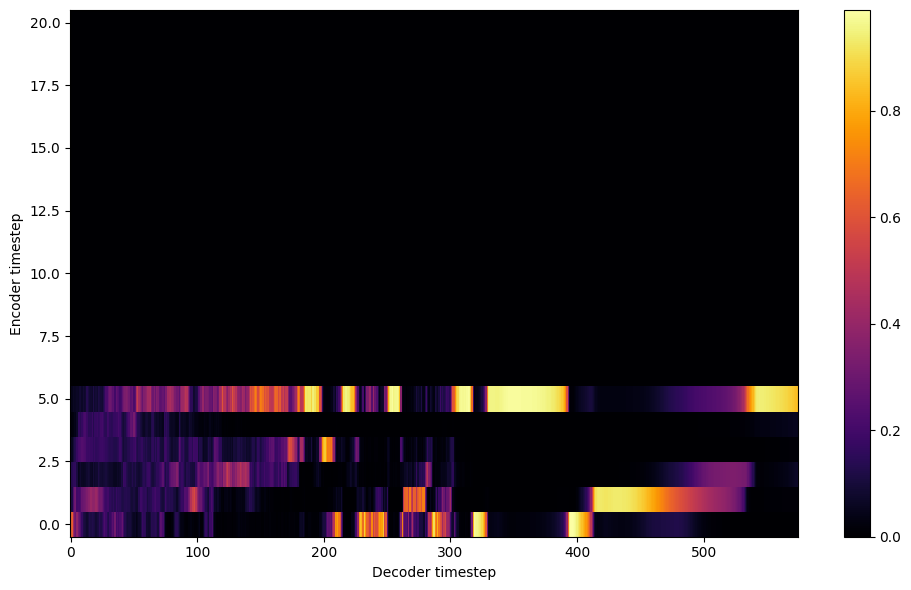

Saving model and optimizer state at iteration 672 to /content/drive/My Drive/colab/outdir/ukrainian_test_mykyta_non_trans
Model Saved

Starting Epoch: 8 Iteration: 672


  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 8 Validation loss 756:  0.248275  Time: 4.7m LR: 0.000010


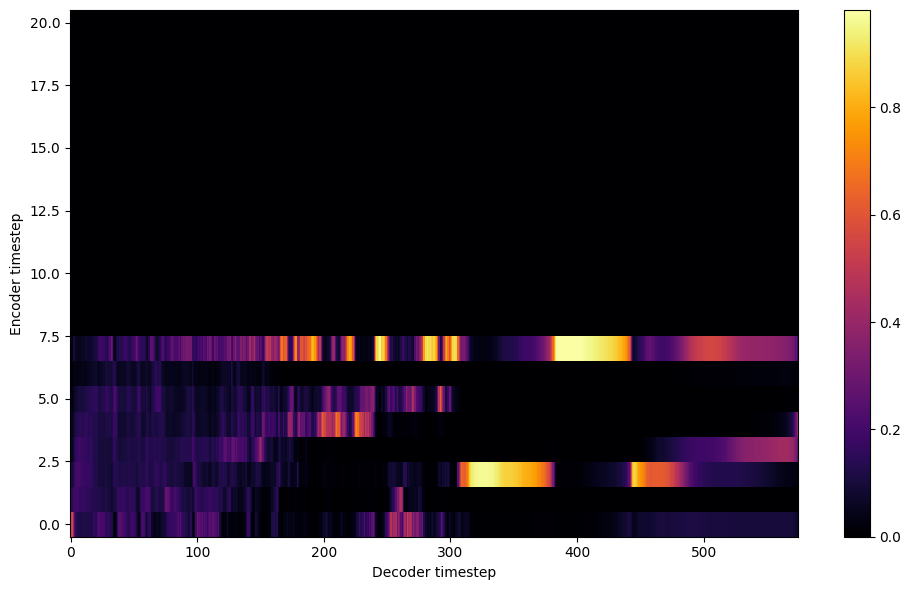

Saving model and optimizer state at iteration 756 to /content/drive/My Drive/colab/outdir/ukrainian_test_mykyta_non_trans
Model Saved

Starting Epoch: 9 Iteration: 756


  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 9 Validation loss 840:  0.243531  Time: 4.6m LR: 0.000010


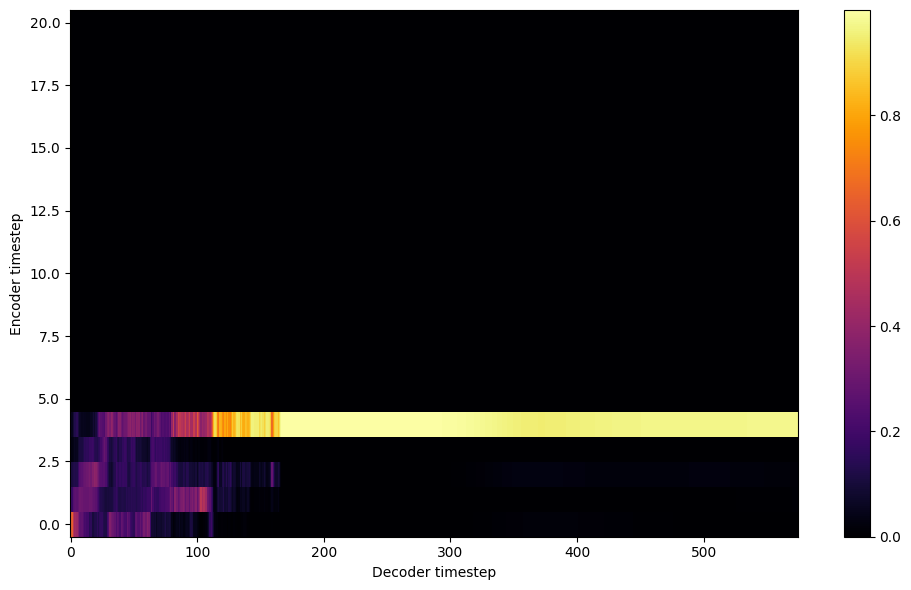

Saving model and optimizer state at iteration 840 to /content/drive/My Drive/colab/outdir/ukrainian_test_mykyta_non_trans
Model Saved

Starting Epoch: 10 Iteration: 840


  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 10 Validation loss 924:  0.240866  Time: 4.7m LR: 0.000010


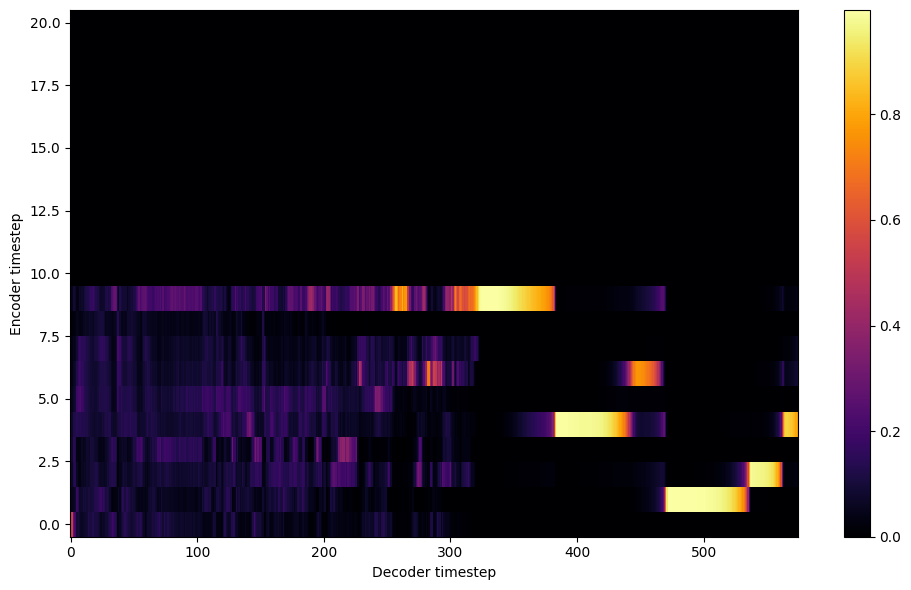

Saving model and optimizer state at iteration 924 to /content/drive/My Drive/colab/outdir/ukrainian_test_mykyta_non_trans
Model Saved

Starting Epoch: 11 Iteration: 924


  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 11 Validation loss 1008:  0.238175  Time: 4.7m LR: 0.000010


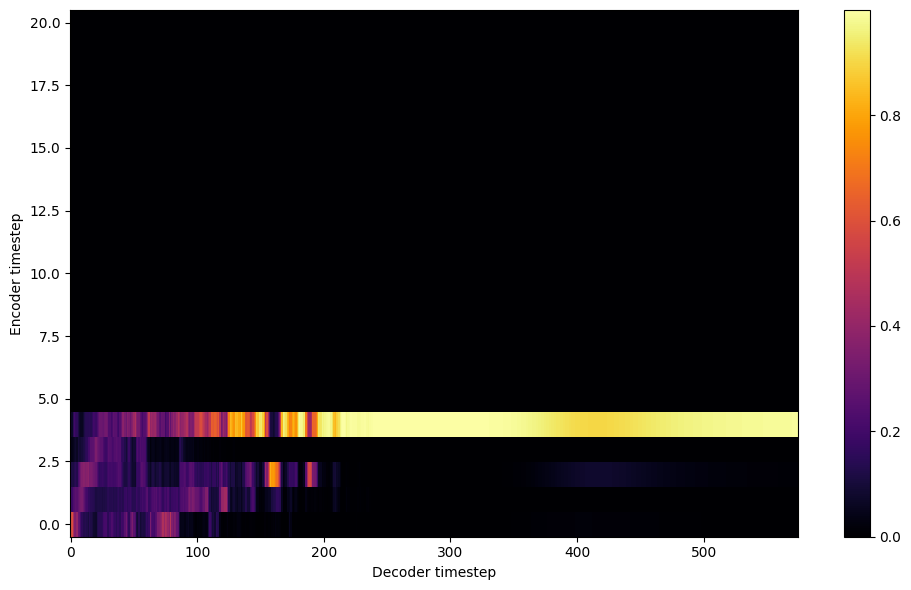

Saving model and optimizer state at iteration 1008 to /content/drive/My Drive/colab/outdir/ukrainian_test_mykyta_non_trans
Model Saved

Starting Epoch: 12 Iteration: 1008


  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 12 Validation loss 1092:  0.234745  Time: 4.7m LR: 0.000010


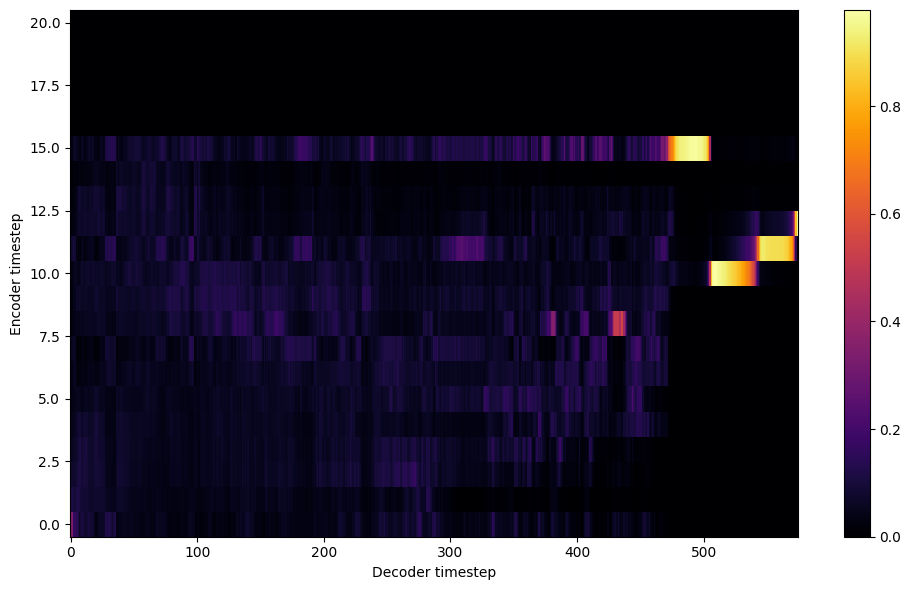

Saving model and optimizer state at iteration 1092 to /content/drive/My Drive/colab/outdir/ukrainian_test_mykyta_non_trans
Model Saved

Starting Epoch: 13 Iteration: 1092


  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 13 Validation loss 1176:  0.232383  Time: 4.7m LR: 0.000010


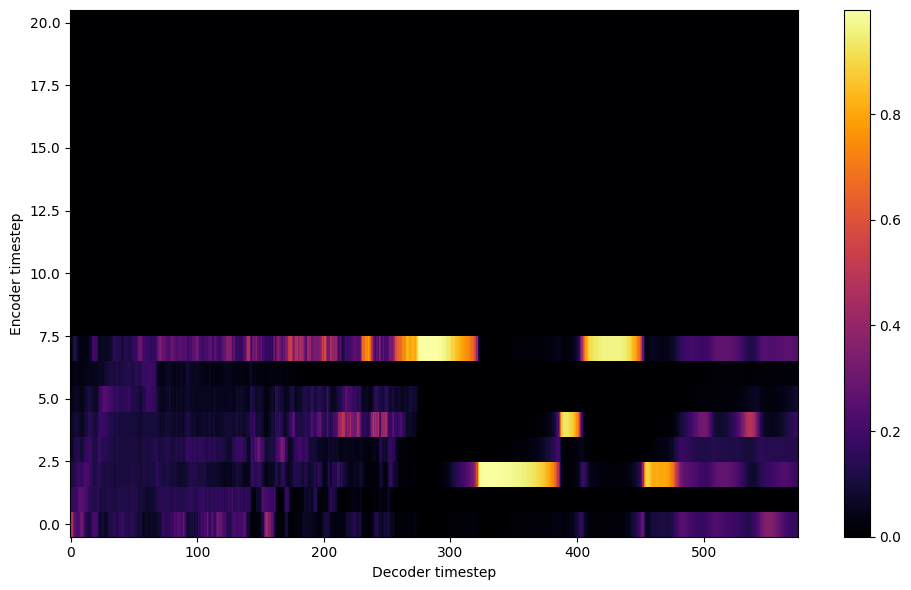

Saving model and optimizer state at iteration 1176 to /content/drive/My Drive/colab/outdir/ukrainian_test_mykyta_non_trans
Model Saved

Starting Epoch: 14 Iteration: 1176


  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 14 Validation loss 1260:  0.231240  Time: 4.7m LR: 0.000010


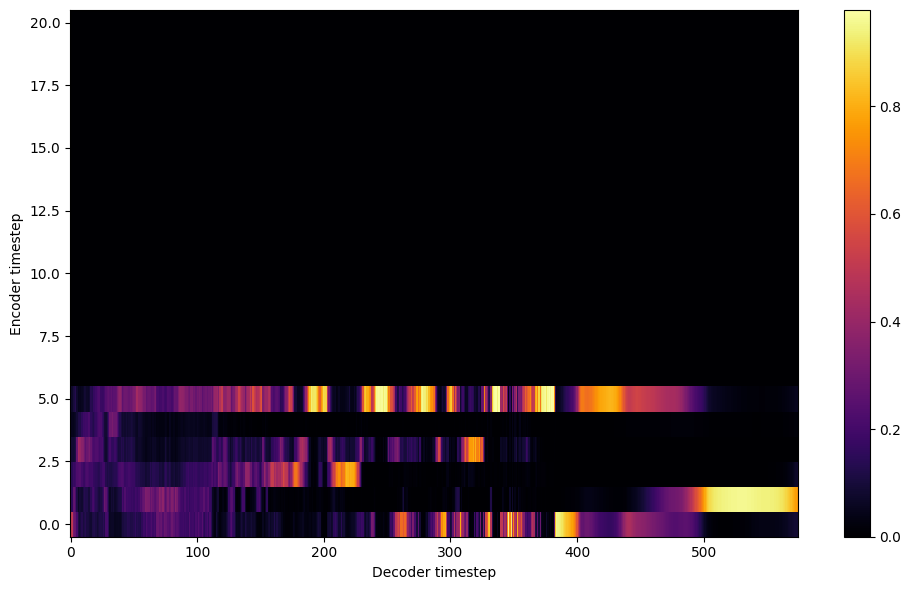

Saving model and optimizer state at iteration 1260 to /content/drive/My Drive/colab/outdir/ukrainian_test_mykyta_non_trans
Model Saved

Starting Epoch: 15 Iteration: 1260


  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 15 Validation loss 1344:  0.227861  Time: 4.6m LR: 0.000010


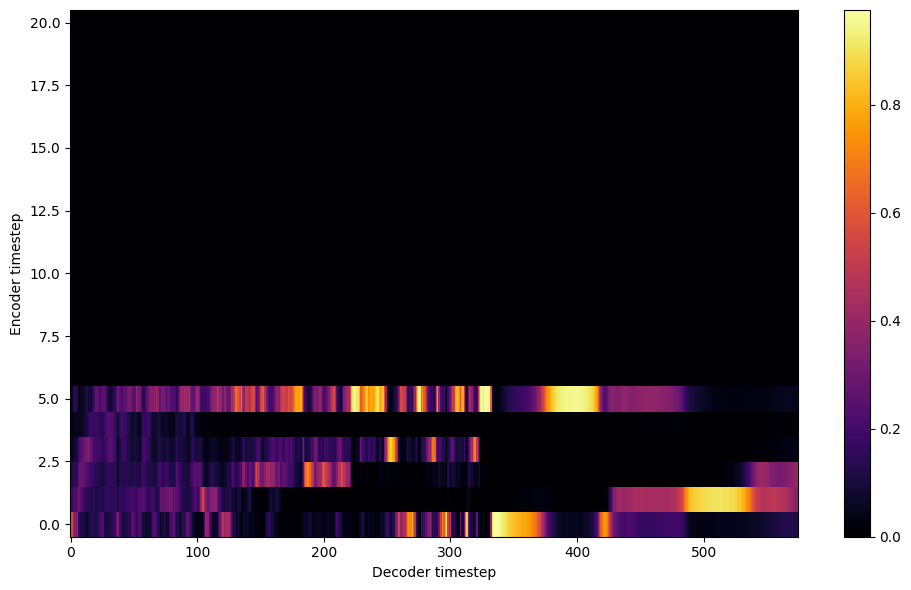

Saving model and optimizer state at iteration 1344 to /content/drive/My Drive/colab/outdir/ukrainian_test_mykyta_non_trans
Model Saved

Starting Epoch: 16 Iteration: 1344


  0%|          | 0/84 [00:00<?, ?it/s]

In [ ]:
train(output_directory, log_directory, checkpoint_path, warm_start, n_gpus, rank, group_name, hparams, log_directory2)